In [1]:
import pickle
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.datasets import make_moons
from sklearn.neighbors import kneighbors_graph  
from sklearn.decomposition import PCA
from scipy.linalg import fractional_matrix_power
import pickle
import matplotlib.pyplot as plt
import pandas as pd


def load_data(file):
    data_list = []
    label_list = []
    for i in range(1,6):
        with open(f"{file}/data_batch_{i}", 'rb') as f:
            _data = pickle.load(f, encoding="bytes")
            #import pdb; pdb.set_trace()
            data_list.append(_data[b'data'])
            label_list.append(_data[b'labels'])
    return (data_list, label_list)
            
data_cifar10 = load_data("./cifar10")

In [2]:
data, label = data_cifar10
data = np.concatenate(data)
label = np.concatenate(label)
data= (data - np.mean(data, axis=1)[:,np.newaxis])/(np.var(data, axis=1)[:,np.newaxis])

selected_labels = [2, 4, 8, 9]

selected_data = np.zeros(data.shape[0]).astype(bool)

for l in selected_labels:
    selected_data = np.bitwise_or(selected_data, label == l)
    

data = data[selected_data]
label[label==2] -= 2
label[label==4] -= 3
label[label==8] -= 6
label[label==9] -= 6
label = label[selected_data]

In [3]:
num_data = data.shape[0]
random_index = np.arange(num_data)
np.random.default_rng(123).shuffle(random_index)
print(random_index)
data = data[random_index]
label = label[random_index]

[12807 14435 12181 ...   302 14043  7321]


In [4]:
def pca_dim_reduce(X, output_dim=20):
    
    pca = PCA(n_components = output_dim)
    newData = pca.fit_transform(X)
    return newData


def generate_affinity_matrix(X, r, k):

    A = kneighbors_graph(X, n_neighbors=r, include_self=False).toarray()

    W = A
    Ap = A
    for i in range(2, k+1):
        Ap = Ap@A

        W = W + Ap
        # W = W + np.linalg.matrix_power(A, i)

    np.fill_diagonal(W, 0)
    
    D_n12 = np.sum(W, axis=1)**(-1/2)
    D_n1 = np.sum(W, axis=1)**(-1)
    D_n12 = np.diag(D_n12)
    D_n1 = np.diag(D_n1)
    return W, D_n12, D_n1

def walk_matrix(X, r, k, m_type='norm'):
    if m_type == 'norm':
        W, D_n12, _ = generate_affinity_matrix(X, r, k)
        S = D_n12 @ W @ D_n12
        return S
    elif m_type == 'random':
        W, _, D_n1 = generate_affinity_matrix(X, r, k)
        S = W @ D_n1
        return  S
    else:
        raise NotImplemented()


def label_matrix(label_vec):
    #one-hot
    n_values = np.max(label_vec) + 1
    one_hot_y = np.eye(n_values)[label_vec]
    return one_hot_y

        
def lgc(S, Y, alpha=0.99,num_I=400):
    
    # Iteration 0/ F_0 = Y
    F = Y
    for t in range(num_I):
        F = S @ F * alpha + (1-alpha)*Y
    
    return F

In [5]:
# alpha = 0.99
alpha=0.6

labeled_num = 500
sample_num = 5000
Y = np.zeros([sample_num, 4])
data_exp = pca_dim_reduce(data, output_dim=64)
# data_exp = data
data_exp = data_exp[:sample_num]
print(data_exp.shape)
target = label[:sample_num]
matrix = label_matrix(label[:labeled_num])
Y[:labeled_num] = matrix

acc_dict = {}
num_iter_list = [1,2,5,10,100,1000]
r_list = [1,2,3,4,5]
k_list = [1,2,3,4,5]

for num_iter in num_iter_list:
    for r in r_list:
        for k in k_list:

            S = walk_matrix(data_exp, r=r, k=k, m_type='random')

            F = lgc(S, Y, alpha, num_iter)

            pred_y = np.argmax(F, axis=-1)
            acc = np.mean(pred_y[labeled_num:] == target[labeled_num:])
            acc_dict[(num_iter, r, k)] = acc
            print(f'num_iter = {num_iter}, r={r}, k={k}, acc={acc:.5f}')



(5000, 64)
num_iter = 1, r=1, k=1, acc=0.28578
num_iter = 1, r=1, k=2, acc=0.31111
num_iter = 1, r=1, k=3, acc=0.33311
num_iter = 1, r=1, k=4, acc=0.34556
num_iter = 1, r=1, k=5, acc=0.35000
num_iter = 1, r=2, k=1, acc=0.31622
num_iter = 1, r=2, k=2, acc=0.38378
num_iter = 1, r=2, k=3, acc=0.42467
num_iter = 1, r=2, k=4, acc=0.42489
num_iter = 1, r=2, k=5, acc=0.42022
num_iter = 1, r=3, k=1, acc=0.34178
num_iter = 1, r=3, k=2, acc=0.43600
num_iter = 1, r=3, k=3, acc=0.45933
num_iter = 1, r=3, k=4, acc=0.45022
num_iter = 1, r=3, k=5, acc=0.44667
num_iter = 1, r=4, k=1, acc=0.36622
num_iter = 1, r=4, k=2, acc=0.47467
num_iter = 1, r=4, k=3, acc=0.47444
num_iter = 1, r=4, k=4, acc=0.45800
num_iter = 1, r=4, k=5, acc=0.44222
num_iter = 1, r=5, k=1, acc=0.38533
num_iter = 1, r=5, k=2, acc=0.48667
num_iter = 1, r=5, k=3, acc=0.47822
num_iter = 1, r=5, k=4, acc=0.45800
num_iter = 1, r=5, k=5, acc=0.44222
num_iter = 2, r=1, k=1, acc=0.31111
num_iter = 2, r=1, k=2, acc=0.34600
num_iter = 2, r=1

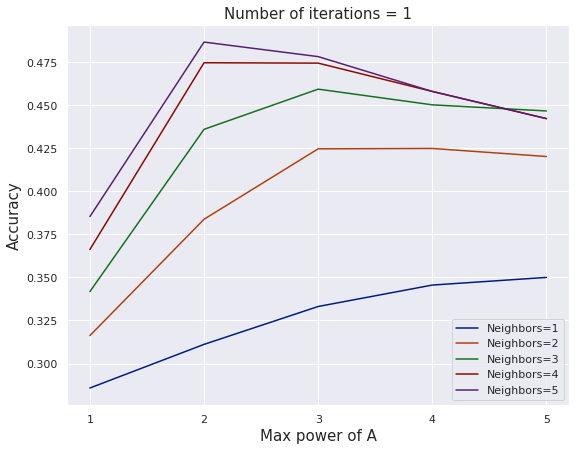

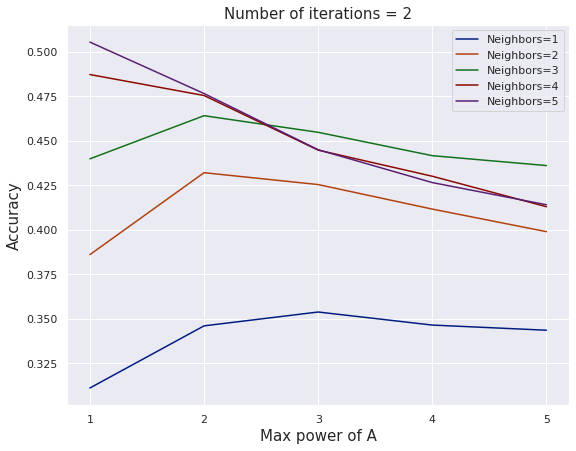

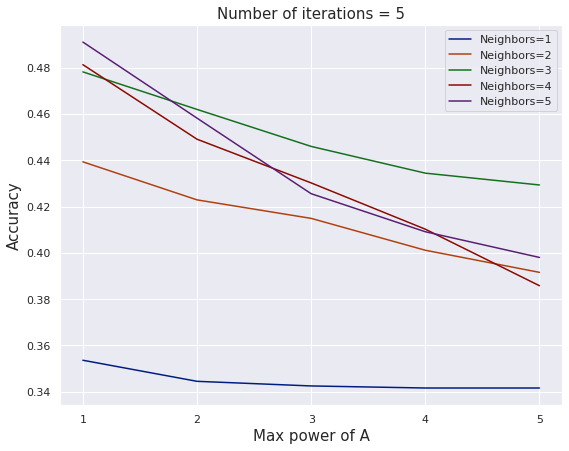

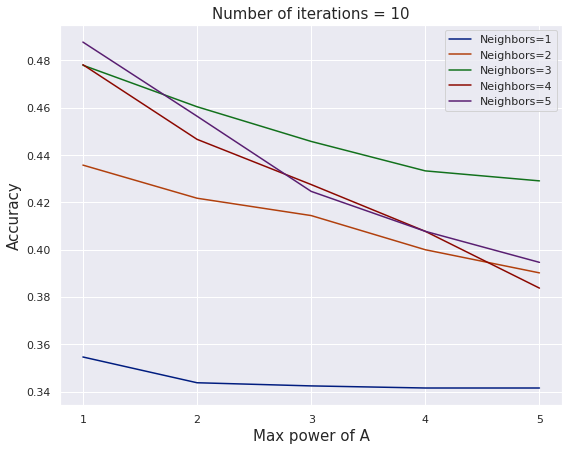

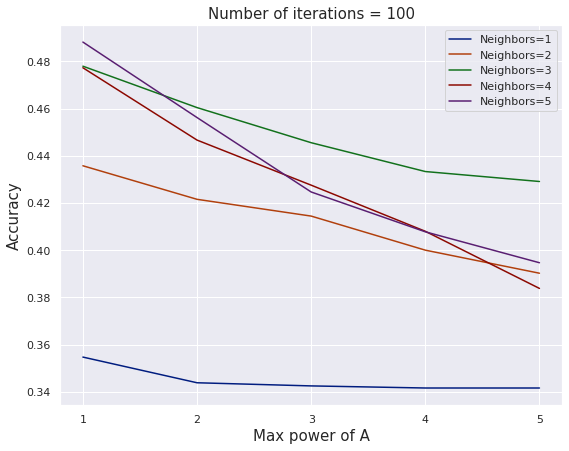

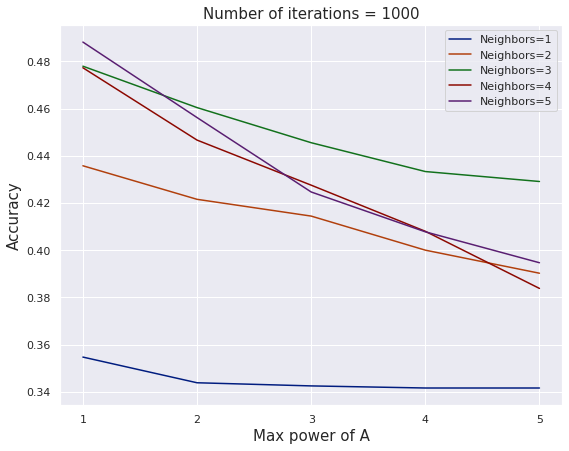

In [10]:
import seaborn as sns
import numpy as np; np.random.seed(1)

# import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid", palette = "dark")

for num_iter in num_iter_list:
    plt.figure()
    for r in r_list:

        plot = sns.lineplot(x=k_list, y=[acc_dict[(num_iter, r, k)] for k in k_list], label=f'Neighbors={r}')
        plot.figure.set_figwidth(9)
        plot.figure.set_figheight(7)

    plot.set_xticks(range(1, 6))
    plot.set_xlabel('Max power of A', fontsize=15)
    plot.set_ylabel('Accuracy', fontsize=15)
    plot.set_title(f'Number of iterations = {num_iter}', fontsize=15)
   
    plt.savefig(f'num_iter_{num_iter}.pdf', dpi=300)